In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, re, random, time
import matplotlib as mpl
from venny4py.venny4py import *

import cobra
from cobra import Model, Reaction, Metabolite, flux_analysis

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup
pal4 = sns.color_palette("mako",4)
pal3 = sns.color_palette("mako",3)
pal2 = [sns.color_palette("mako",4)[3],sns.color_palette("mako",4)[0]]
pal22 = [sns.color_palette("mako",4)[0],sns.color_palette("mako",4)[3]]

folder = '../data/'

def set_exchanges(model,to_set):
    for x in model.boundary:
        x.bounds = (0.0, 1000.0)
    for x in to_set:
        model.reactions.get_by_id(x).lower_bound = -1000.0
    return model


In [3]:
# load 
# annotation table
df_rxns = pd.read_excel(folder+'curatedPotatoGEM_annotation_table.xlsx')
df_rxns['pws'] = df_rxns.Pathway.str.split('|')
print(df_rxns.shape)
print(df_rxns.blocked.sum())
df_rxns

# model
model = cobra.io.read_sbml_model(folder+'curatedPotatoGEM.xml')

co_ratio = model.problem.Constraint(
    model.reactions.RBC_h.flux_expression - model.reactions.RBO_h.flux_expression * (10.7/3.72),
    lb=0,
    ub=0)
model.add_cons_vars(co_ratio)

obj = 'Bio_Stu_leaf'
model.objective = obj

model


(7092, 35)
67
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-16


Name,model
Memory address,1fd1d70a840
Number of metabolites,3801
Number of reactions,7092
Number of genes,2173
Number of groups,0
Objective expression,1.0*Bio_Stu_leaf - 1.0*Bio_Stu_leaf_reverse_466da
Compartments,"c, h, hm, x, m, r, g, pm, cut, ohm, mm, ob, imm, l, rm, pg"


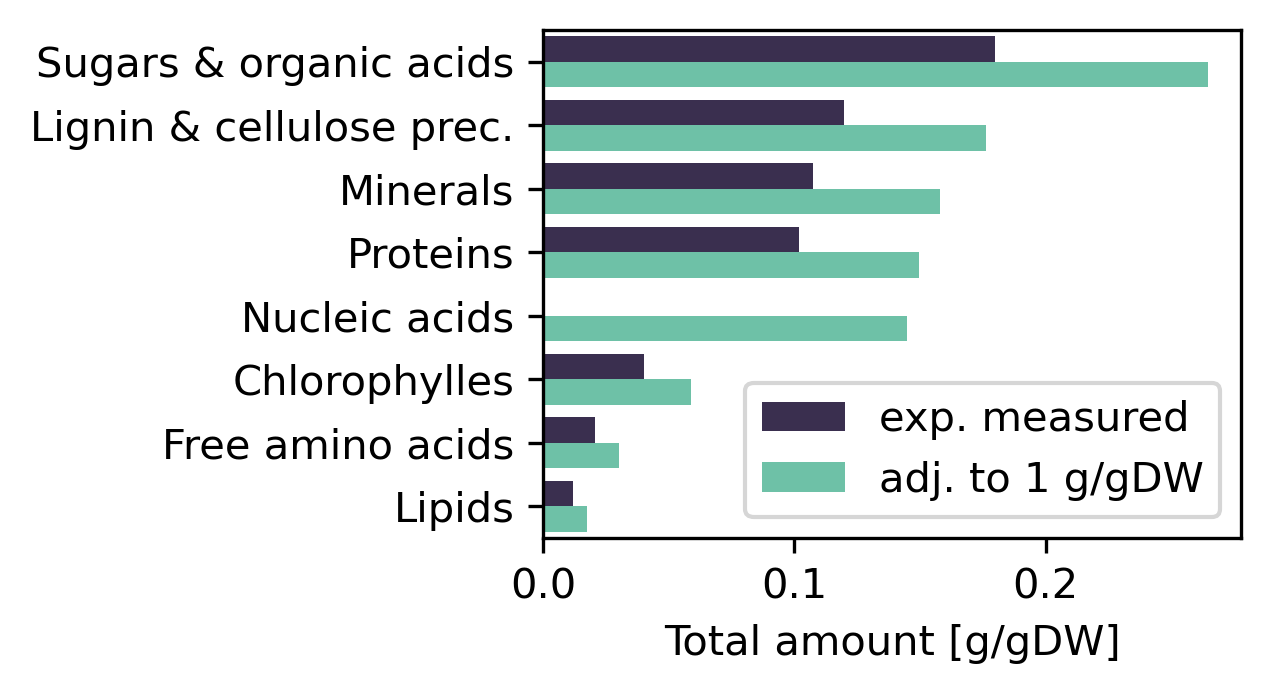

In [4]:
# biomass plot
biomass = pd.read_csv(folder+'biomass_table_potato_leaf-sums_2023_8_10.tsv',sep='\t')
biomass_uneq = pd.read_csv(folder+'biomass_table_potato_leaf-sums_2023_8_10-unequilibrated.tsv',sep='\t')
biomass_uneq.loc[biomass_uneq.compound=='Nucleic acids',
                'ggdw'] = 0

# plot equalized vs unequalized
names = ['Sugars & organic acids',
        'Lignin & cellulose prec.',
         'Minerals',
         'Proteins',
         'Nucleic acids',
         'Chlorophylles',
         'Free amino acids',
         'Lipids'
        ]

# add
biomass['ggdw_uneq'] = biomass_uneq.ggdw

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))
sns.barplot(data=biomass
            .sort_values(by='ggdw',ascending=False)
            .melt(id_vars=['compound'],value_vars=['ggdw_uneq','ggdw']),
           y='compound',x='value',hue='variable',
            palette=pal22
           )
plt.xlabel('Total amount [g/gDW]')
plt.yticks([0,1,2,3,4,5,6,7],names)
L = plt.legend()
L.get_texts()[0].set_text('exp. measured')
L.get_texts()[1].set_text('adj. to 1 g/gDW')
plt.ylabel('')
plt.show()


In [5]:
# supplement
biomass

,compound,ggdw,mmolgdw,ref,organism,mw,include,ggdw_uneq
0,Proteins,0.149664,1.186396,This study,Solanum tuberosum,NaN,True,0.101755
1,Free amino acids,0.017357,0.129689,"Schauer et al. 2005, This study, Peksa et al. ...","Solanum lycopersicum, Solanum tuberosum",NaN,True,0.011801
2,Sugars and organic acids,0.264605,1.435698,"This study, Hastilestari et al. 2018, Schauer ...","Solanum tuberosum, Solanum lycopersicum",NaN,True,0.179903
3,Lipids,0.058833,0.161419,Correa et al. 2023,Solanum tuberosum,NaN,True,0.040000
4,Lignin and (hemi)cellulose precursors,0.176352,1.039783,Gerlin et al. 2021,Solanum lycopersicum,NaN,True,0.119900
5,Chlorophylles,0.030073,0.033557,Gerlin et al. 2021,Solanum lycopersicum,NaN,True,0.020446
6,Minerals,0.158117,3.746029,"Chea et al. 2021, Kirkby & Mengel 1967",Solanum tuberosum,NaN,True,0.107502
7,Nucleic acids,0.145000,0.430464,This study: inferred,Solanum tuberosum,NaN,True,0.000000


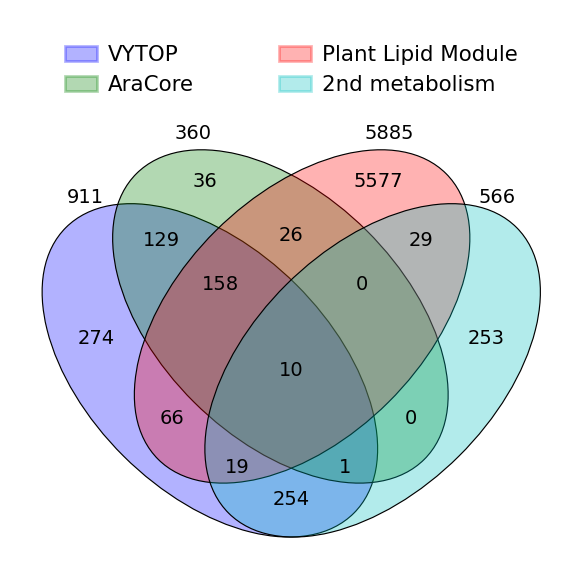

298
279


In [6]:
# fig 1a

#dict of sets
sets = {
    'VYTOP': set(df_rxns[df_rxns.tomato].Abbreviation.tolist()),
    'AraCore': set(df_rxns[df_rxns.aracore].Abbreviation.tolist()),
    'Plant Lipid Module': set(df_rxns[df_rxns.lpm].Abbreviation.tolist()),
    '2nd metabolism': set(df_rxns[df_rxns.second].Abbreviation.tolist())}
    
venny4py(sets=sets) # fixed color scheme
plt.show()

# text values
print((df_rxns.aracore&df_rxns.tomato).sum())
print(((df_rxns.aracore|df_rxns.tomato)&df_rxns.lpm).sum())


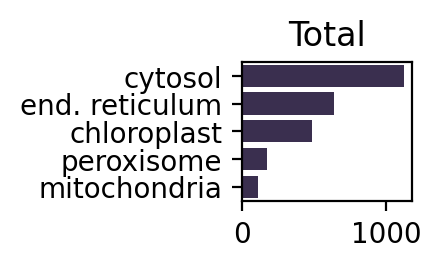

In [7]:
# fig 1b
df_rxns = df_rxns.replace({'comp':{'endopl. reticulum': 'end. reticulum'}})
df_rxns.comp.value_counts()

tmp = df_rxns.comp.value_counts().reset_index() 
tmp

plt.figure(figsize=(1.1,0.9))
sns.barplot(data=tmp,y='comp',x='count',color=pal22[0],
           order=['cytosol','end. reticulum','chloroplast','peroxisome','mitochondria'], #, 'vacuole'],
           )
plt.ylabel('')
plt.xlabel('')
plt.title('Total')
plt.show()

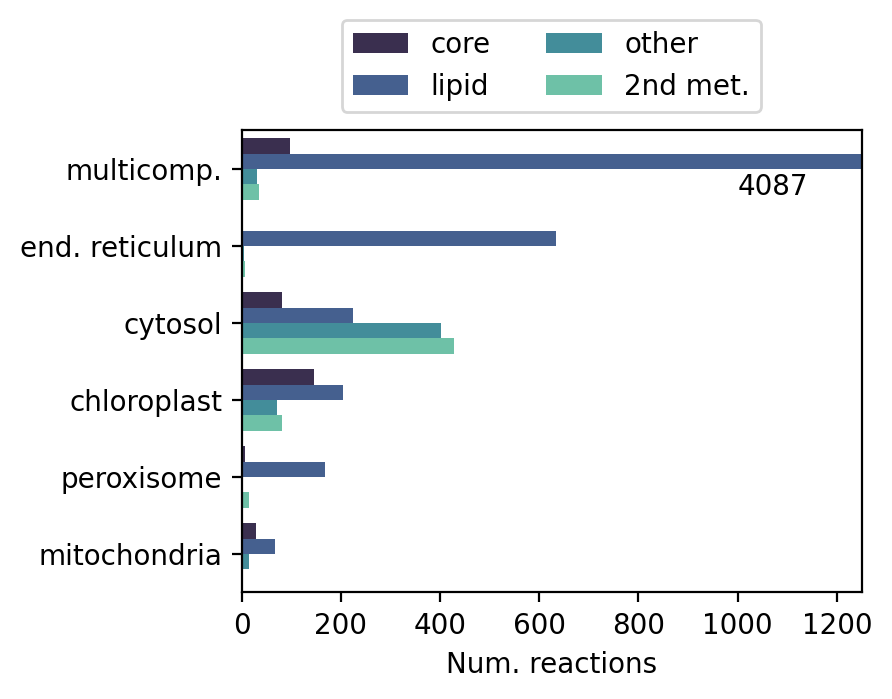

In [8]:
# construct count table
df_plot = df_rxns[df_rxns.aracore==True].comp.value_counts().reset_index()
df_plot['type'] = 'core'
tmp = df_rxns[df_rxns.lipid==True].comp.value_counts().reset_index()
tmp['type'] = 'lipid'
df_plot = pd.concat([df_plot,tmp])
tmp = df_rxns[df_rxns.other==True].comp.value_counts().reset_index()
tmp['type'] = 'other'
df_plot = pd.concat([df_plot,tmp])
tmp = df_rxns[df_rxns.second==True].comp.value_counts().reset_index()
tmp['type'] = '2nd met.'#'second'
df_plot = pd.concat([df_plot,tmp])

# # subset
subset = df_rxns.comp.unique()[:-1] # drop 
df_plot = df_plot.query('comp.isin(@subset)')
df_plot

order=(df_plot.query('comp.isin(@subset)')
                   .groupby('comp')
                   ['count'].max()
                   .sort_values(ascending=False)
                .index.tolist()
                )
order

plt.figure(figsize=(4,3))
sns.barplot(data=df_plot.sort_values(by=["comp"]),
            x='count',y='comp',hue='type',
            order=order,
            hue_order=['core','lipid','other','2nd met.'],
            palette=pal4 
           )
plt.ylabel('')
plt.xlabel('Num. reactions')
plt.xlim(0,1250)
plt.legend(ncol=2, bbox_to_anchor=(0.86,1.27))
plt.text(1000,0.33,
         str(df_plot.query('type=="lipid"').query('comp=="multicomp."')['count'].values[0]),
        )

plt.show()


(8427, 36) 6055
(2372, 36) 0
(1037,)
(1056,)
ontology    secondary metabolite biosynsuper pathwaysaroma...
all                                                      2372
blocked                                                 122.0
dtype: object


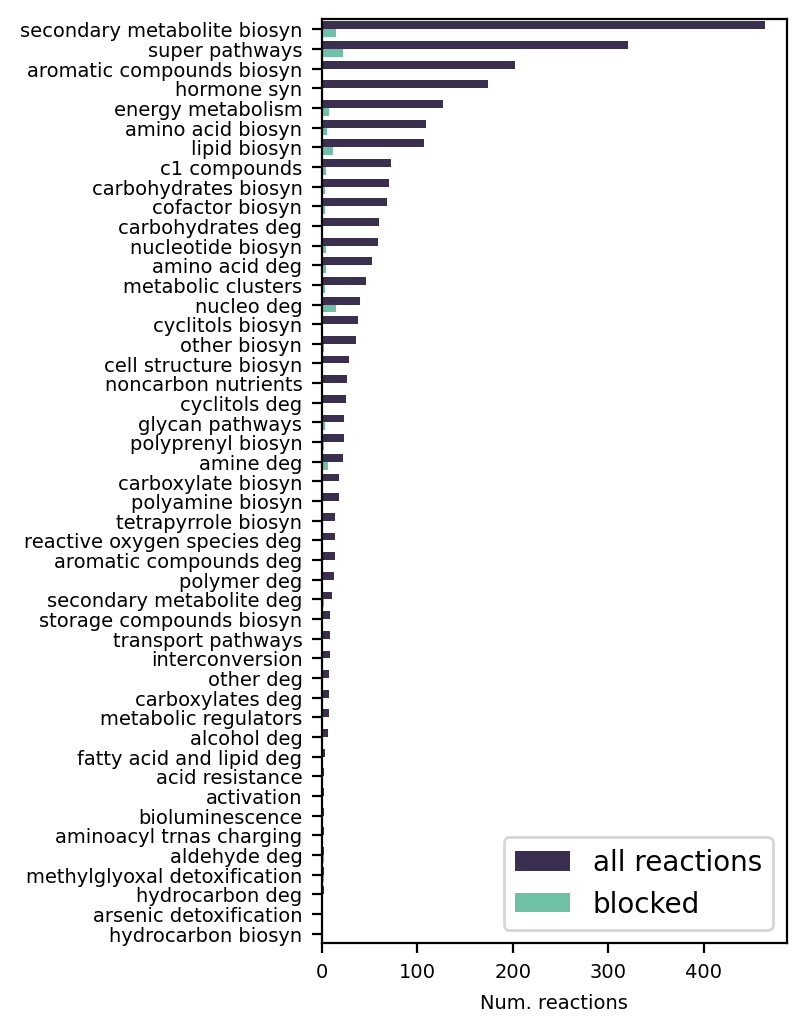

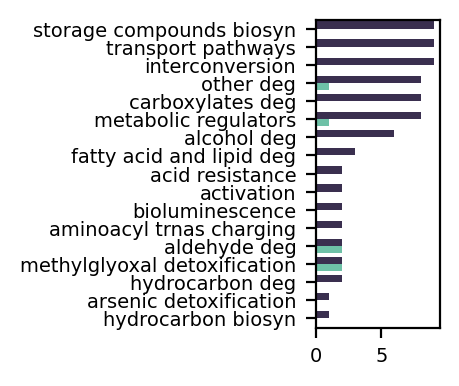

In [9]:
# fix 1c
# prepare table
df_rxns2 = df_rxns.copy(deep=True)
df_rxns2['ontology'] = df_rxns2.Ontology.str.split('|')
df_rxns2 = df_rxns2.explode('ontology')
print(df_rxns2.shape, df_rxns2['ontology'].isna().sum())
df_rxns2 = df_rxns2.dropna(subset=['ontology'])
print(df_rxns2.shape, df_rxns2['ontology'].isna().sum())

# how many ontology annotated pws
print(df_rxns2.Abbreviation.unique().shape)
print(df_rxns.dropna(subset='Pathway').Abbreviation.unique().shape)

# plot
# add blocked
tmp = (df_rxns2.groupby('ontology')
       .Abbreviation.count()
       .rename('all')
       .reset_index()
       .merge(df_rxns2.query('blocked==True')
              .groupby('ontology')
              .Abbreviation.count()
              .rename('blocked')
              .reset_index(),
              on='ontology',how='left'
             )
      .fillna(0)
       .sort_values(by=['all'],ascending=False)
      )
print(tmp.sum()) # sanity check
tmp

plt.figure(figsize=(3,6))
sns.barplot(data=tmp.melt(id_vars='ontology',value_vars=['all','blocked']),
            y='ontology',x='value',
            hue='variable',palette=pal22 #['k','steel']
           )
plt.xlabel('Num. reactions',fontsize=7)
L = plt.legend(loc='lower right')
L.get_texts()[0].set_text('all reactions')
L.get_texts()[1].set_text('blocked')
plt.ylabel('')
plt.tick_params(labelsize=7)
plt.show()

# inset
df_plot = tmp.melt(id_vars='ontology',value_vars=['all','blocked']).query('value<10')
df_plot = df_plot[df_plot.ontology.isin(df_plot.query('variable=="all"').ontology)]

plt.figure(figsize=(0.8,2))
sns.barplot(data=df_plot,
            y='ontology',x='value',
            hue='variable',palette=pal22, #['k','steel']
            #legend=False
           )
plt.xlabel('')
plt.legend([], [], frameon=False)
plt.ylabel('')
plt.tick_params(labelsize=7)
plt.show()

67
1163


<Figure size 600x300 with 0 Axes>

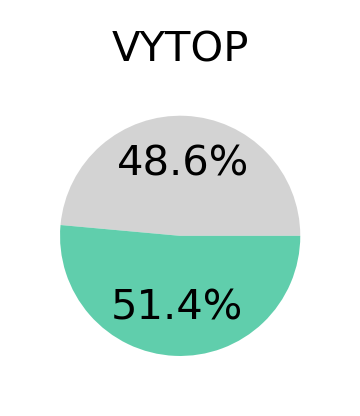

<Figure size 600x300 with 0 Axes>

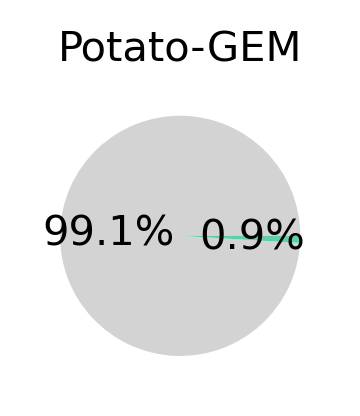

In [10]:
# pie charts
# load
blocked = df_rxns.query('blocked==True').Abbreviation.tolist()
print(len(blocked))
blocked_gerlin = pd.read_csv(folder+'blocked_gerlin_10_8_23.csv')
print(len(blocked_gerlin))

# pie how many ec annotated in eggnog
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,1))
(pd.DataFrame([['',2261-len(blocked_gerlin)],
             ['',len(blocked_gerlin)]],columns=['name',''])
 .set_index('name')
 .plot.pie(subplots=True,
           figsize=(1.3,1.3),
          legend='',
          autopct='%1.1f%%',
          colors=['lightgrey',pal22[1]]
          )
)
plt.title('VYTOP',fontsize=10)
plt.show()

# pie how many ec annotated in eggnog
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,1))
(pd.DataFrame([['',df_rxns.shape[0]-len(blocked)],
             ['',len(blocked)]],columns=['name',''])
 .set_index('name')
 .plot.pie(subplots=True,
           figsize=(1.3,1.3),
          legend='',
          autopct='%1.1f%%',
          colors=['lightgrey',pal22[1]]
          )
)
plt.title('Potato-GEM',fontsize=10)
plt.show()


In [11]:
# functions
def test_single_production_ld(model,biomass,to_set):
    
    # set exchanges 
    if len(to_set)>0:
        
        for x in model.boundary:
            x.lower_bound=0
        
        for x in to_set:
            model.reactions.get_by_id(x).lower_bound = -1000.0

    # make test dic for each specific components
    # add all reactions to model
    dic_list = []
    results = []
    for idx,row in biomass.iterrows():
        #print(idx)
        dic_list.append({row.id:
            -1000*row.mmolgdw,
            #'biomass_leaf_b':1
            })

        rxn_leaf = Reaction('Test_production_'+row.id)
        rxn_leaf.name = 'Test_production: '+row.compound
        rxn_leaf.subsystem = ''
        rxn_leaf.reversibility = False
        rxn_leaf.lower_bound = 0.
        rxn_leaf.upper_bound = 1000.0 #99999.

        # add rxn to model
        model.add_reactions([rxn_leaf])
        rxn_leaf.add_metabolites(dic_list[-1])

        # run test
        # set model objective
        model.objective = 'Test_production_'+row.id

        # check basic fba
        solution = flux_analysis.pfba(model) #model.optimize()
        tmp = solution.to_frame()
        results.append(solution)

        # remove rxn from model
        model.reactions[-1].remove_from_model()

    # add results to frame
    biomass['flux'] = [x.objective_value for x in results]
    biomass['num_rxns'] = [x.to_frame().query('fluxes>0').shape[0] for x in results]

    # plot
    no_plot = ['NO3','NH4','SO4','Pi',  'Ca', 'Cl', 'Fe', 'K', 'Mg', 'Na',]
    mpl.rcParams['figure.dpi'] = 300
    plt.figure(figsize=(13,1.4))
    sns.barplot(data=biomass.query('~compound.isin(@no_plot)'),
               x='compound',y='flux',
               palette=['grey']) 
    plt.xticks(rotation=45,ha='right')
    plt.yscale('log')
    plt.ylabel('Predicted flux\n[mmol/gDW/h]')
    plt.xlabel('')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(13,1.4))
    sns.barplot(data=biomass.query('~compound.isin(@no_plot)'),
               x='compound',y='num_rxns',
               palette=['grey']) 
    plt.xticks(rotation=45,ha='right')
    plt.ylabel('Num. reactions\ninvolved')
    plt.tight_layout()
    plt.show()
    
    return biomass


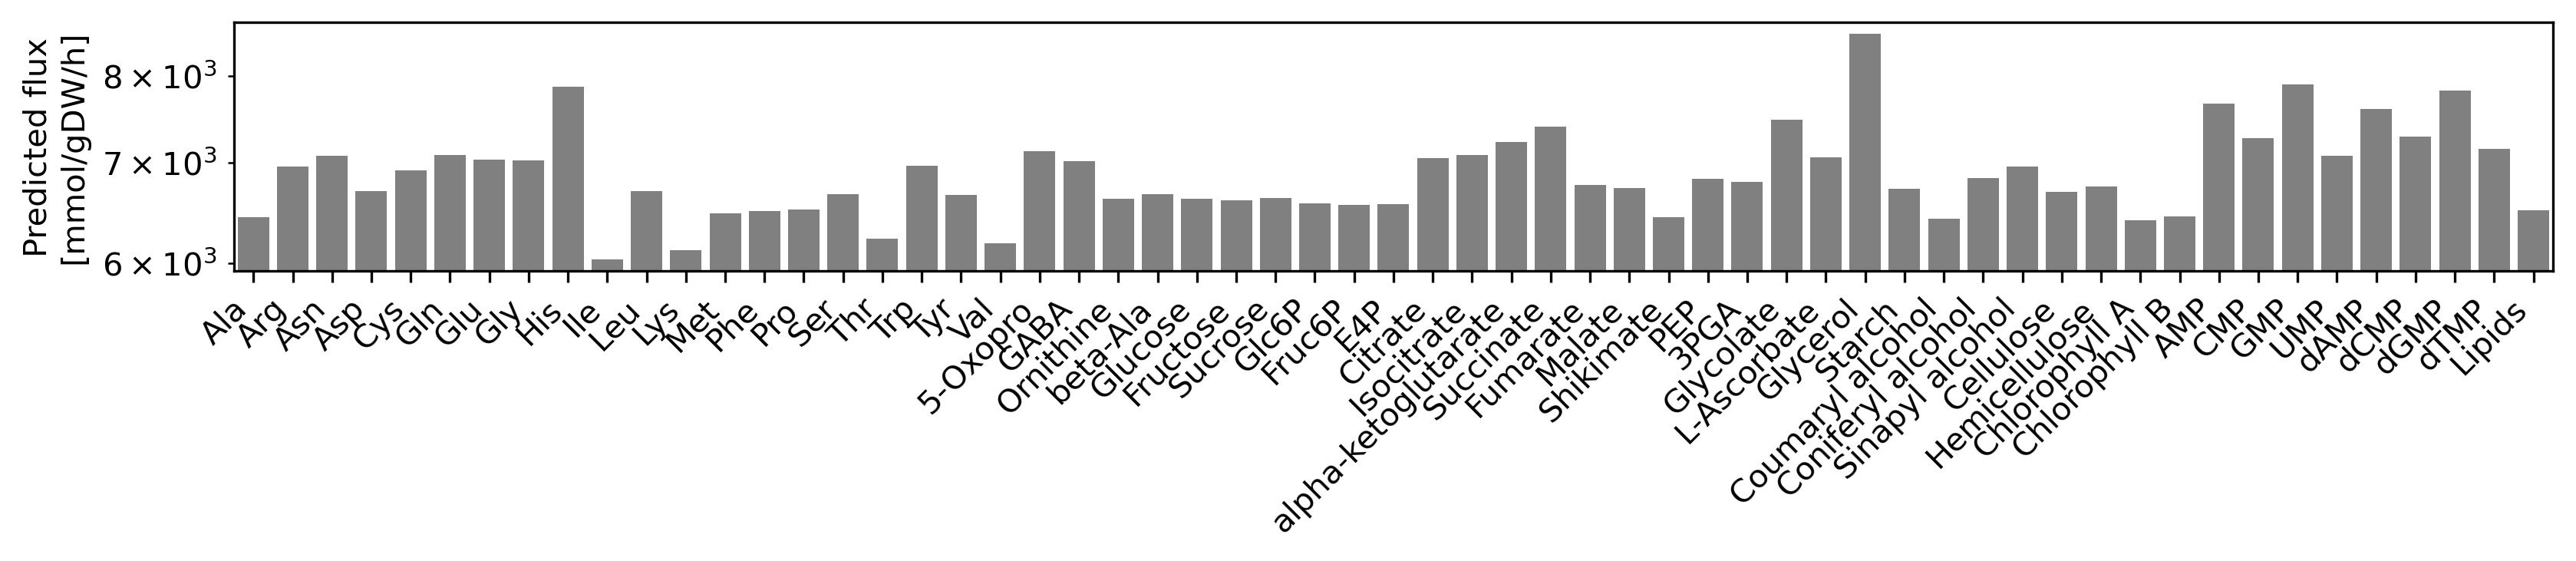

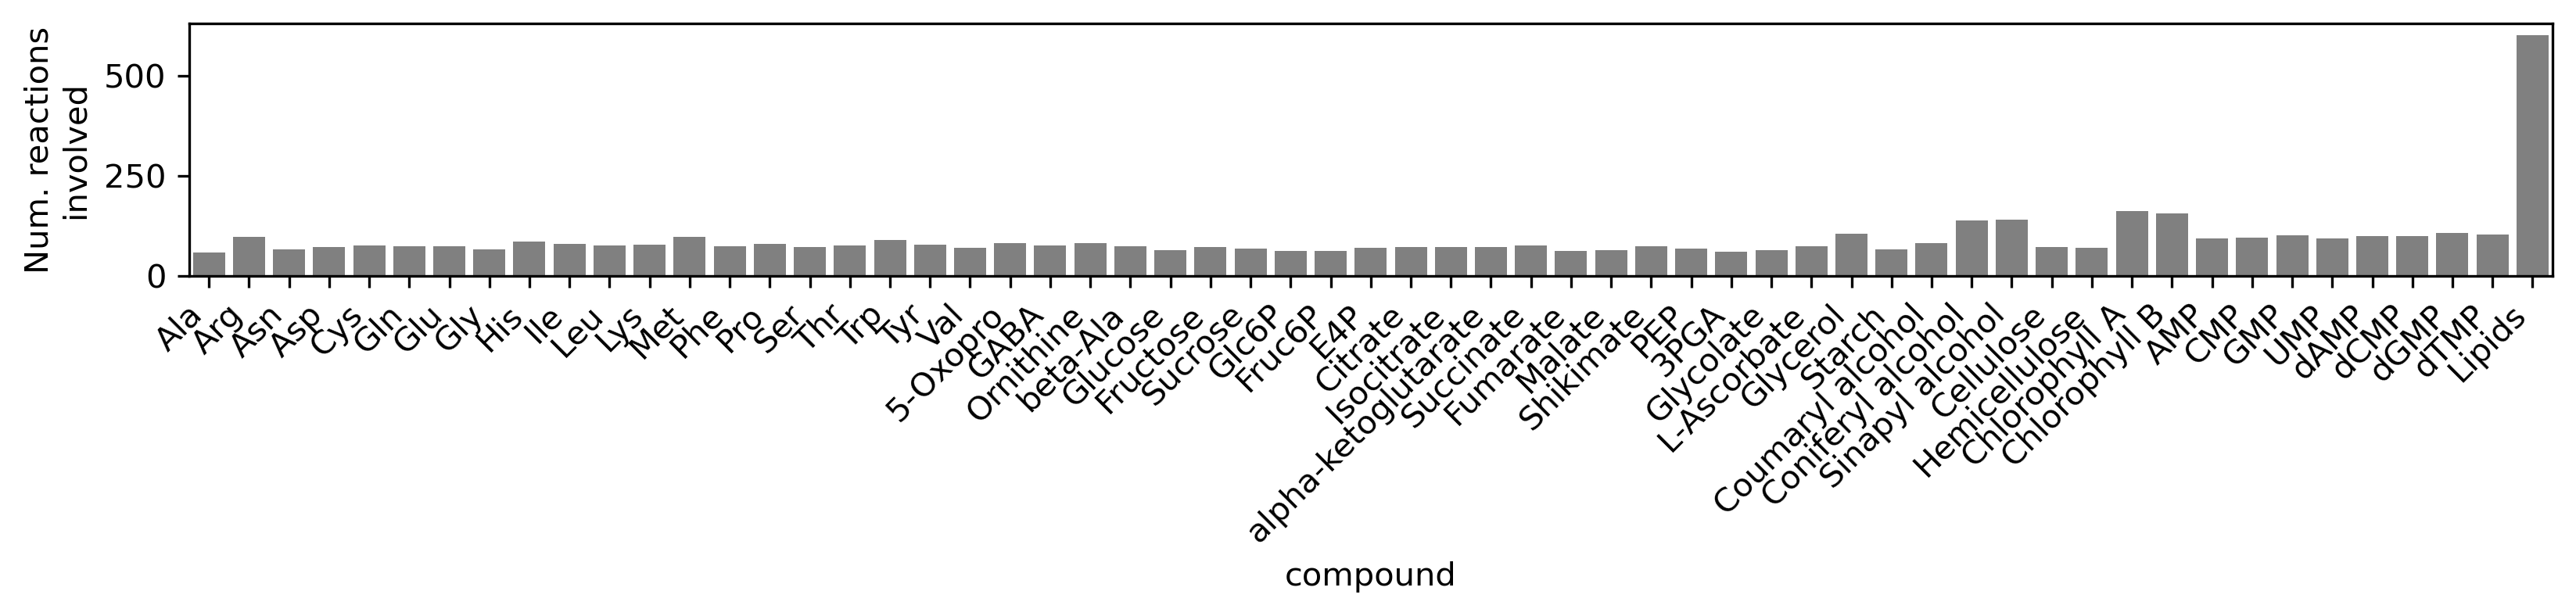

34.97925543785095


In [12]:
# potato
# make test dic for each specific components
# load
biomass = pd.read_csv(folder+'biomass_table_potato_leaf-full_2023_9_6.tsv')
biomass['mmolgdw'] = 1 
biomass

# run
t0 = time.time()
res_potato = test_single_production_ld(model,biomass,[])
print(time.time()-t0)

[15, 45] 60


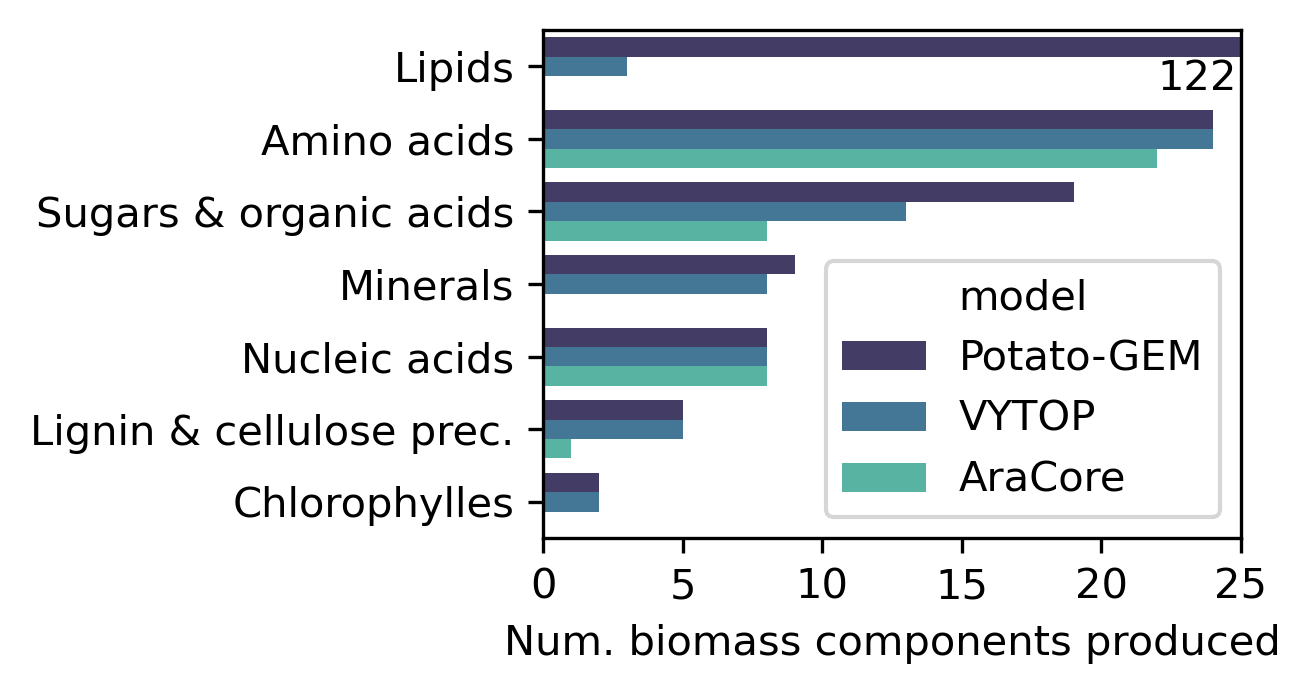

In [13]:
# plot partitioned components, barplot
# num produced across partitions per model type hue

# load
df_multi = pd.read_csv(folder+'model_comparison_biomass_fba.tsv',sep='\t')

# lipids will have to be expanded based on lpm f
# 122 chains and backbones produced by LPM
# 3 FAs produced by tomatogem
lip_rxns = ['SLIMEr_1628','SLIMEr_1629']
lip = []
for l in lip_rxns:
    lip.append(len(model.reactions.get_by_id(l).metabolites))
print(lip, sum(lip))

# table
tmp = (df_multi.groupby(['model','Class'])
            .compound.count()
            .reset_index()
      )

# update
tmp.loc[7,'compound'] = sum(lip)
# palmitic, stearic, linoleic acid
tmp = pd.concat([tmp,pd.DataFrame([['VYTOP','Lipids',3]],columns=tmp.columns)])

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))
sns.barplot(data=tmp,
            y='Class',x='compound',hue='model',
            hue_order=['Potato-GEM','VYTOP','AraCore'],
            order=tmp.query('model=="Potato-GEM"')
            .sort_values(by='compound',ascending=False)['Class']
            .tolist(),
            palette=pal3
           )
plt.xlim(0,25)
plt.xlabel('Num. biomass components produced')
plt.ylabel('')
plt.text(22,0.33,str(122),
        )

plt.show()


In [14]:
# Values for text - % more biomass components
# note lipids disregarded here
tmp2 = tmp.query('Class!="Lipids"').groupby('model').compound.sum()
print(tmp2.iloc[1]/tmp2.iloc[0]-1)
print(tmp2.iloc[1]/tmp2.iloc[2]-1)
tmp2

0.7179487179487178
0.1166666666666667


model
AraCore       39
Potato-GEM    67
VYTOP         60
Name: compound, dtype: int64